# Example: multilayered blanket

In [2]:
import os 
#os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax 
jax.config.update("jax_enable_x64", True)
import jax_sbgeom
import jax.numpy as jnp
from jax_sbgeom.coils import CoilSet, DiscreteCoil, FiniteSizeCoilSet, RotationMinimizedFrame, mesh_coilset_surface
from jax_sbgeom.flux_surfaces import FluxSurfaceNormalExtendedNoPhi, mesh_surface, ToroidalExtent
from jax_sbgeom.flux_surfaces.flux_surfaces_utilities import generate_thickness_matrix
from jax_sbgeom.coils.coil_winding_surface import create_optimized_coil_winding_surface
%load_ext autoreload
%autoreload 2
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh, _vertices_to_pyvista_polyline

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Setting up geometry

Selecting a particular coil and plasma set:

In [3]:
stell_i = 1
vmec_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4",     "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias4_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4",     "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"][stell_i]
coil_file = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS4_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"][stell_i]

We use a FluxSurfaceNormalExtendedNoPhi, as this has the property that $\phi_{in} = \phi_{out}$ even beyond the LCFS (as required by FFTs). Furthermore, the lines are straight, allowing for simple raytracing. 

In [4]:
from jax_sbgeom.flux_surfaces import FluxSurfaceNormalExtendedNoPhi
flux_surface = FluxSurfaceNormalExtendedNoPhi.from_hdf5(vmec_file)
def _get_discrete_coils(coil_file):
    import h5py
    with h5py.File(coil_file, 'r') as f:
        coil_data = jnp.array(f['Dataset1'])
    return CoilSet.from_list([DiscreteCoil.from_positions(coil_data[i]) for i in range(coil_data.shape[0])])
coilset      = _get_discrete_coils(coil_file)

We first optimize the coil winding surface:

In [6]:
n_points_per_coil = 100
n_points_toroidal = 500
cws_optimized = create_optimized_coil_winding_surface(coilset, n_points_per_coil, n_points_toroidal, surface_type = "spline")

We then interpolate using the closest mesh point. The built in raytracing works sufficiently fast here.

In [7]:
def interpolate_normal_coils(coilset, external_mesh, n_coil_samples = 100):
    positions = coilset.position(jnp.linspace(0,1,n_coil_samples, endpoint=False)) #[n_coils, n_coil_samples, 3]    
    
    closest_points, dmin, d_idx = jax_sbgeom.jax_utils.raytracing.get_closest_points_on_mesh(positions, external_mesh)
    
    return positions, jax_sbgeom.jax_utils.utils.surface_normals_from_mesh(external_mesh)[d_idx]

positions, normals = interpolate_normal_coils(coilset, cws_optimized)

We then use the RadialVectorFrame to define normals along the coil and can immediately mesh that:

In [8]:
from jax_sbgeom.coils import FiniteSizeCoilSet, RadialVectorFrame, DiscreteCoil, FiniteSizeCoil

finitesize_coilset = FiniteSizeCoilSet(FiniteSizeCoil(coilset.coils, RadialVectorFrame(normals)))

mesh = mesh_coilset_surface(finitesize_coilset, 100, 0.4, 0.4)

We can then plot the normals computed using the raytracing and the finite size coils:

In [10]:
import pyvista as pv
import numpy as onp
plotter = pv.Plotter()
plotter.add_mesh(_mesh_to_pyvista_mesh(*cws_optimized))

plotter.add_arrows(onp.array(positions.reshape(-1,3)), onp.array(normals.reshape(-1,3)), mag=1.0, color='green')
plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh), color='yellow', opacity=1.0, show_edges=True)
plotter.show()

Widget(value='<iframe src="http://localhost:43623/index.html?ui=P_0x747dac4a4c50_1&reconnect=auto" class="pyvi…

Then, we generate a thickness matrix again using the built-in raytracing:

In [13]:
theta_mg, phi_mg, d_mg = jax_sbgeom.flux_surfaces.flux_surfaces_utilities.generate_thickness_matrix(flux_surface, cws_optimized, n_theta = 210, n_phi = 110)

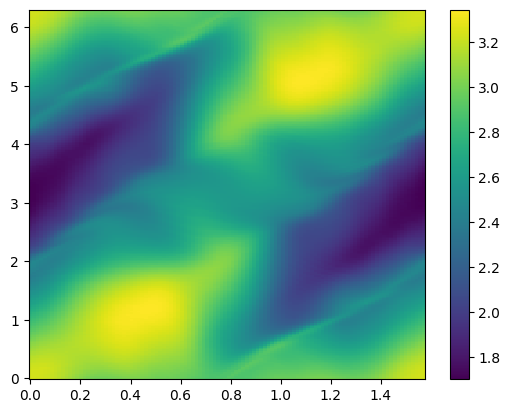

In [14]:
plt.pcolormesh(phi_mg, theta_mg, d_mg)
plt.colorbar()

Some arbitrary non-uniform blanket geometry can then be generated:

In [15]:
fraction_max = 1- ((jnp.max(d_mg) - d_mg) / (jnp.max(d_mg) - jnp.min(d_mg)))**4

In [16]:
finite_size_R = 0.2
breeder_thickness = fraction_max * 0.5 + 0.5
bzz_thickness     = breeder_thickness + 0.2
vv_front          = bzz_thickness + 0.06
vv_shield         = jnp.max(vv_front) + 0.2 - (1- fraction_max) * 0.1
outer             = d_mg - finite_size_R * 0.5

We can then transform using the buil in functions:

In [18]:
from jax_sbgeom.flux_surfaces.convert_to_vmec import  create_fourier_surface_extension_interp_equal_arclength, _create_fluxsurface_from_rmnc_zmns, create_fourier_surface_extension_interp
from jax_sbgeom.flux_surfaces import FluxSurfaceFourierExtended

fs_extensions = []
for i in [jnp.full(breeder_thickness.shape, 0.2), jnp.full(breeder_thickness.shape, 0.4),  breeder_thickness, bzz_thickness, vv_front, vv_shield, outer]:
    d_grid_opt = i    
    fs_extensions.append(create_fourier_surface_extension_interp_equal_arclength(flux_surface, d_grid_opt, n_theta = 100, n_phi = 200, n_theta_sample_arclength = 300))

In [19]:
Rmnc = jnp.stack([fs_extensions[i][0] for i in range(len(fs_extensions))], axis=0)
Zmns = jnp.stack([fs_extensions[i][1] for i in range(len(fs_extensions))], axis=0)
mpol = fs_extensions[0][2]
ntor = fs_extensions[0][3]
extended_fs = _create_fluxsurface_from_rmnc_zmns(Rmnc, Zmns, mpol, ntor, flux_surface.settings.nfp)
fourier_extended = FluxSurfaceFourierExtended.from_flux_surface_and_extension(flux_surface,extended_fs)

This geometry can then be meshed (and we give some different scalar value to each layer):

In [23]:
actual_layers = [0  ,  1, 2,2,  2,3,4, 5]
actual_layers = [0  ,  1, 2,3,4, 5,5]
d = jnp.array([1,2,3,4,5, 6, 6.5, 7])

nv = 100 
nu = 100
mesh_total = jax_sbgeom.flux_surfaces.mesh_tetrahedra(fourier_extended, d + 1.0,  ToroidalExtent(0.0, 2 * jnp.pi / flux_surface.settings.nfp),  nv, nu,)

n_layers = len(d) - 1

n_layer = 6 * (nv-1) * nu

total_array_layers = onp.zeros((n_layer * n_layers))
for i in range(n_layers):
    total_array_layers[i * n_layer:(i + 1) * n_layer] = actual_layers[i] + 0.5

In [21]:
fs_truncated = jax_sbgeom.coils.coilset.filter_coilset_phi(finitesize_coilset, 0.0, 2 * jnp.pi / flux_surface.settings.nfp)
mesh_coilset = jax_sbgeom.coils.mesh_coilset_surface(fs_truncated, 100, finite_size_R, finite_size_R)

In [81]:
def _boundary_normal_vectors_from_tetrahedron(tetrahedron : jnp.ndarray):
    '''
    Create a boundary vector from tetrahedron

    Parameters
    -----------
    tetrahedron : jnp.ndarray [..., 4,3] 
        Tetrahedron vertex locations
    Returns
    -------
    boundary : jnp.ndarray [..., 4,3]
        Normal
    '''
    v0 = tetrahedron[...,1,:] - tetrahedron[...,0,:]
    v1 = tetrahedron[...,2,:] - tetrahedron[...,0,:]
    v2 = tetrahedron[...,3,:] - tetrahedron[...,0,:]
    v3 = tetrahedron[...,2,:] - tetrahedron[...,1,:]
    v4 = tetrahedron[...,3,:] - tetrahedron[...,1,:]
    n0 = jnp.cross(v0, v1)
    n1 = jnp.cross(v2, v0)
    n2 = jnp.cross(v1, v2)
    n3 = jnp.cross(v4, v3)
    normals = jnp.stack([n0, n1, n2, n3], axis=-2)
    normals = normals / jnp.linalg.norm(normals, axis=-1, keepdims=True) * jnp.sign(jnp.sum( (v0 * jnp.cross(v2, v1)), axis= -1, keepdims=True))
    return normals


def _boundary_centroids_from_tetrahedron(tetrahedron : jnp.ndarray):
    '''
    Create the centroids of all boundaries from tetrahedron

    Parameters
    -----------
    tetrahedra : jnp.ndarray [..., 4,3] 
        Tetrahedron vertex locations
    Returns
    ------- 
    centroids : jnp.ndarray [..., 4,3]
        Centroids
    
    '''
    v0 = tetrahedron[...,0,:]
    v1 = tetrahedron[...,1,:]
    v2 = tetrahedron[...,2,:]
    v3 = tetrahedron[...,3,:]
    c0 = (v0 + v1 + v2) / 3.0
    c1 = (v0 + v1 + v3) / 3.0
    c2 = (v0 + v2 + v3) / 3.0
    c3 = (v1 + v2 + v3) / 3.0
    centroids = jnp.stack([c0, c1, c2, c3,], axis=-2)
    return centroids

tetrahedra_total = mesh_total[0][mesh_total[1]]


In [84]:
dd = 1000
part_t = tetrahedra_total[0:1000:dd]
mesh_trunc = (mesh_total[0], mesh_total[1][0:1000:dd])

In [85]:
plotter = pv.Plotter()

plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh_trunc))
centroids = onp.array(_boundary_centroids_from_tetrahedron(part_t).reshape(-1,3))
normals  = onp.array(_boundary_normal_vectors_from_tetrahedron(part_t).reshape(-1,3))
plotter.add_mesh(pv.PolyData(centroids), color='red', point_size=10, render_points_as_spheres=True)
plotter.add_arrows(centroids, normals, mag=0.2, color='blue')
plotter.show()

Widget(value='<iframe src="http://localhost:43623/index.html?ui=P_0x747bc5b1d130_22&reconnect=auto" class="pyv…

In [ ]:
def _tetrahedral_intersection_test(tetrahedron_1 : jnp.ndarray, tetrahedron_2 : jnp.ndarray) -> jnp.ndarray:
    """Tests whether two tetrahedra intersect.

    Args:
        tetrahedron_1: A (4, 3) array of the vertices of the first tetrahedron.
        tetrahedron_2: A (4, 3) array of the vertices of the second tetrahedron.

    Returns:
        A boolean indicating whether the two tetrahedra intersect.
    """
    


This code below generates the exact figure including a discrete scalar bar.

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyvista as pv
import numpy as np
pv_mesh = _mesh_to_pyvista_mesh(*mesh_total)
pv_mesh.cell_data["layer"] = total_array_layers

# Example: 7 discrete layers
n_layers = np.max(total_array_layers) + 1 - 0.5   # Adjust based on your actual layers
print(n_layers - 0.5)
# Pick a set of visually distinct colors (shuffled rainbow or any you like)
colors = [
    "#2166AC",  # FW    – deep blue
    "#FBAE17",  # BZ    – warm golden
    "#B2182B",  # SS    – rich red
    "#5AB4AC",  # VVF   – teal
    "#B8E186",  # SH    – light green ✅
    "#D6604D",  # VVB   – coral
]

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Custom labels for each layer
layer_labels = ['FW', 'BZ', 'SS', 'VVF', 'SH', 'VVB']

# When adding the mesh in PyVista, use the colormap and set discrete color mapping
plotter = pv.Plotter(window_size=[1800, 1080])
plotter.add_mesh(
    pv_mesh,
    scalars='layer',
    show_edges=True,
    edge_color="black",
    opacity=1.0,
    edge_opacity=0.5,
    cmap=cmap,
    categories=True,
    clim=[0, n_layers],
    annotations={i + 0.5: label for i, label in enumerate(layer_labels)},
    scalar_bar_args={
        'n_labels': 0,
        'title': "",
        'label_font_size': 36,
        #'draw_ticks': False,  # Remove tick marks
        # 'vertical': True,   # Optional: set to False for horizontal bar
    }
)
plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh_surface(flux_surface, 1.0, ToroidalExtent(0.0, 2 * jnp.pi), 400,400)), color="white", show_edges=False , opacity = 0.1)
#plotter.add_mesh(lcfs.to_pyvista(), color="white", show_edges=False , opacity = 0.1)
plotter.camera.position = (0.2197126762537991, -14.330790719222364, -12.116033772614689)
plotter.camera.focal_point = (13.00164344641068, 1.234163284956215, -1.7337604370920208)
plotter.camera.up =  (0.2551492534709114, 0.38274192703561394, -0.8879231249056989)
plotter.add_mesh(_mesh_to_pyvista_mesh(*mesh_coilset), color='white', show_edges=True, opacity=1.0)
plotter.show()


5.5


Widget(value='<iframe src="http://localhost:43623/index.html?ui=P_0x747bf0d0c2f0_2&reconnect=auto" class="pyvi…